In [1]:
cd ..

/home/ulfaslak@gmail.com/backup/pipeline_code


In [2]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from py_pcha.PCHA import PCHA
from scipy.spatial import ConvexHull

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
import numpy as np
import pandas as pd
import json
from collections import defaultdict, Counter
from datetime import datetime as dt

In [3]:
## General variables
TMPFIGPATH = "visualisation/figures/"
FIGPATH = "../../master_thesis/figures/"

## General dictionaries
with open('globals/feature_name_map.json') as infile:
    feature_name_map = json.load(infile)
with open('globals/super_traits.json') as infile:
    super_traits = json.load(infile)
with open('globals/trait_sign.json') as infile:
    trait_sign = json.load(infile)

## Load data
Xtz = np.loadtxt("data/Xtz.csv", delimiter=",")

Xtz_clean_svm = np.loadtxt("data/Xtz_clean_svm.csv", delimiter=",")
Xtz_clean_kd = np.loadtxt("data/Xtz_clean_kd.csv", delimiter=",")

Xtz_clean_svm_valid_users = np.loadtxt("data/Xtz_clean_svm_valid_users.csv", delimiter=",")
Xtz_clean_kd_valid_users = np.loadtxt("data/Xtz_clean_kd_valid_users.csv", delimiter=",")

feat_names = np.load("data/X_2014_%s_feat_names_sorted.pickle" % None)
    
## General functions
def cl(f):
    return '_'.join(('_'.join(f.split("__allweek__allday__"))).split("__"))
def cp(f):
    return ' '.join([w.capitalize() for w in f.split('_')])
def trytrytry(func):
    """Simple decorator to run functions till they return without error."""
    def wrapper(*args):
        while True:
            try:
                return func(*args)
            except KeyboardInterrupt:
                break
            except:
                pass
    return wrapper

# Find trade-off systems

In [4]:
pca = PCA(n_components=38).fit(Xtz_clean_kd)
A_q = abs(pca.components_.T * (1 / pca.explained_variance_ratio_))

('For n_clusters =', 2, 'The average silhouette_score is :', 0.46555626124312804)


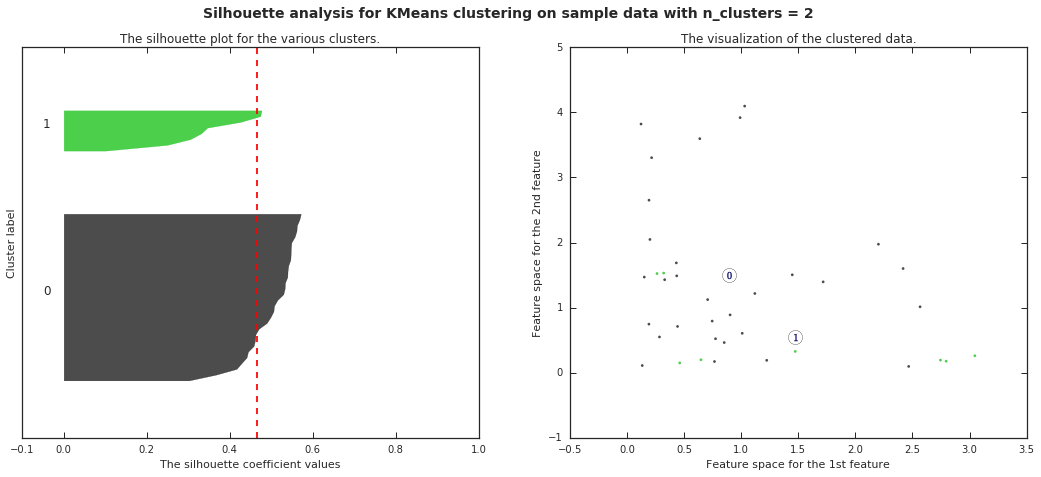

('For n_clusters =', 3, 'The average silhouette_score is :', 0.26530509066024832)


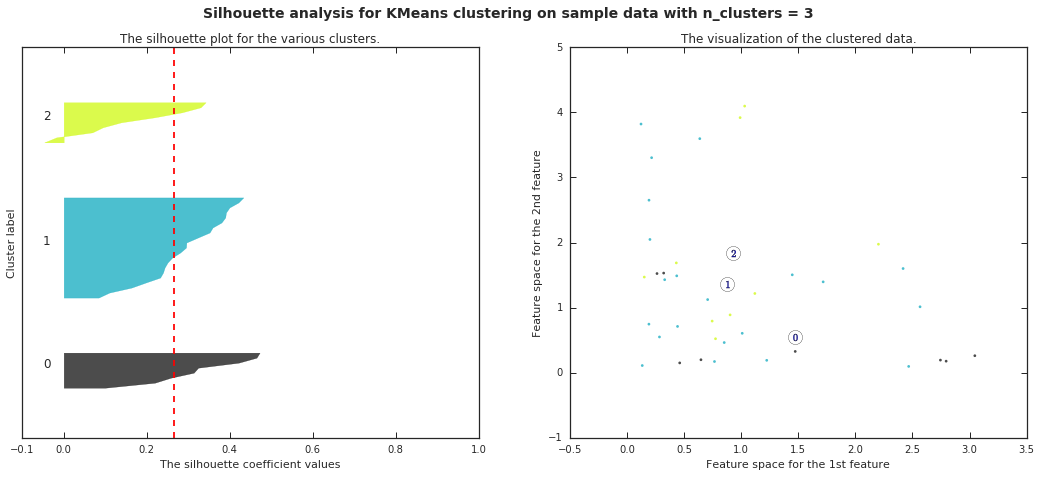

('For n_clusters =', 4, 'The average silhouette_score is :', 0.27330513625067548)


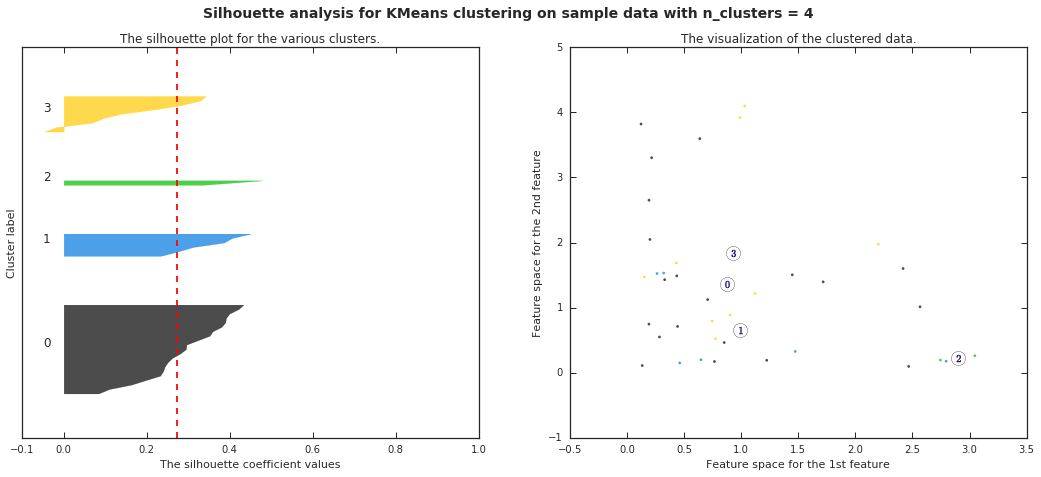

('For n_clusters =', 5, 'The average silhouette_score is :', 0.19394332663742808)


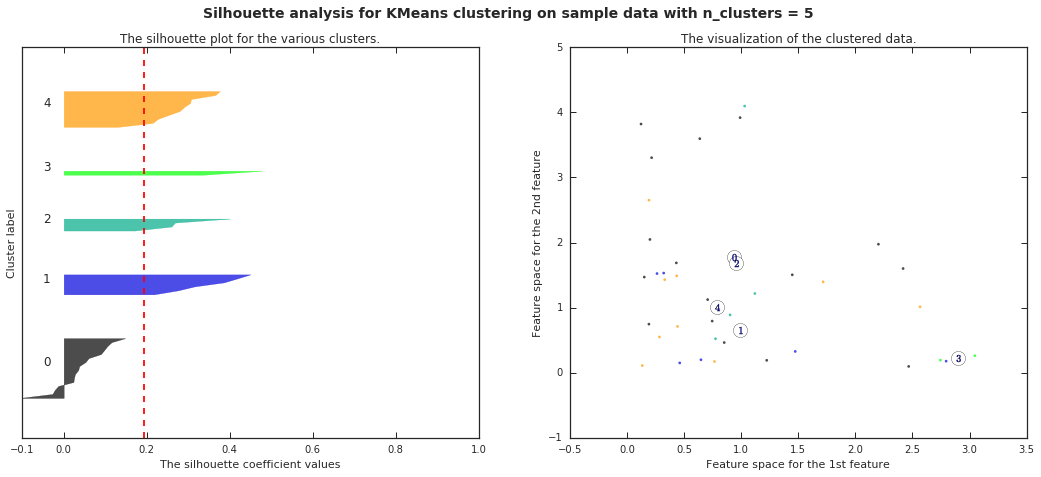

In [5]:
# Generating the sample data from make_blobs
# This particular setting has one distict cluster and 3 clusters placed close
# together.
X = A_q

rs = np.random.randint(1000)

range_n_clusters = range(2, 6)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=rs)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

#### Two is seemingly the best number of clusters

In [6]:
clusters = KMeans(n_clusters=2).fit(A_q).predict(A_q)
sorted(zip(map(str, clusters), [feature_name_map[n] for n in feat_names]), key=lambda x: x[0])

[('0', u'Has many phone contacts'),
 ('0', u'Has long ongoing text conversations'),
 ('0', u'Avoids looking at phone when social'),
 ('0', u'Makes long calls'),
 ('0', u'Spends long time with people'),
 ('0', u'Frequently calls and texts'),
 ('0', u'Around people a lot'),
 ('0', u'Response time to texts depends on receiver'),
 ('0', u'Response time to missed calls depends on receiver'),
 ('0', u'Sends more texts than receives'),
 ('0', u'Responds quickly to missed calls'),
 ('0', u'Responds quickly to texts'),
 ('0', u'Responds to texts immediately'),
 ('0', u'Prefers calling over texting'),
 ('0', u'Mostly goes in groups'),
 ('0', u'Meets people from school outside of school'),
 ('0', u'Mostly meets people at campus'),
 ('0', u'Spends time at campus'),
 ('0', u'Meets with people in weekly patterns'),
 ('0', u'Interacts with strangers'),
 ('0', u'Visits many places only once'),
 ('0', u'Distributes time at different locations evenly'),
 ('0', u'Visits many different places'),
 ('0', u'

# Find appropriate number of archetypes

In [7]:
def p_in_hull(points, p):
    if points.shape[1] > 8:
        print("Not doing it. Too many dimensions. Computer will break.")
        return
    if list(ConvexHull(points).vertices) == list(ConvexHull(np.append(points, p, axis=0)).vertices):
        return True
    else:
        return False
    
def col_shuf(arr):
    arr = arr.copy()
    for i in range(arr.shape[1]):
        np.random.shuffle(arr[:, i])
    return arr

In [8]:
arc_significant_feats = ["Initiates most phone conversations", "Goes places often", "Spends short time at locations", "Calls some people more than others", "Spends long time with people", "Makes long calls", "Meets people at night", "Getting final word when texting depends on receiver", "Mostly meets people at campus", "Responds quickly to missed calls", "Meets people at night", "Meets with people in weekly patterns", "Initiates most text conversations", "Returns calls and responds to texts", "Frequently calls and texts", "Sends more texts than receives", "Concludes text conversations", "Meets with people in weekly patterns", "Has many phone contacts", "Goes many places at night", "Interacts with strangers", "Frequently calls and texts", "Getting final word when texting depends on receiver", "Meets people at night", "Visits many places only once", "Uses phone at night", "Frequently calls and texts", "Has many phone contacts", "Meets people at night", "Selective text and call response rate", "Mostly meets people at campus", "Initiates most phone conversations", "Meets with people in weekly patterns", "Goes places often", "Returns calls and responds to texts", "Calls some people more than others"]
arc_significant_feats = ["Initiates most phone conversations", "Goes places often", "Spends long time with people", "Makes long calls", "Mostly meets people at campus", "Responds quickly to missed calls", "Initiates most text conversations", "Returns calls and responds to texts", "Frequently calls and texts", "Sends more texts than receives", "Meets with people in weekly patterns", "Has many phone contacts", "Goes many places at night", "Interacts with strangers", "Frequently calls and texts", "Frequently calls and texts", "Has many phone contacts", "Meets people at night", "Selective text and call response rate", "Mostly meets people at campus", "Initiates most phone conversations", "Meets with people in weekly patterns", "Goes places often", "Returns calls and responds to texts"]
arc_significant_feats = ["Initiates most phone conversations", "Goes places often", "Spends long time with people", "Mostly meets people at campus", "Initiates most text conversations", "Returns calls and responds to texts", "Frequently calls and texts", "Meets with people in weekly patterns", "Has many phone contacts", "Goes many places at night", "Frequently calls and texts", "Has many phone contacts", "Meets people at night", "Selective text and call response rate", "Mostly meets people at campus", "Initiates most phone conversations", "Meets with people in weekly patterns"]

In [15]:
"""H_0: The ratio between archetype and convex hull volumes is not greater for unshuffled data."""

arcs = range(3,7)
delta = 0.0
maxruns = 20
num_iter = 2
    
p_values = defaultdict(list)
t_ratio_orig = defaultdict(list)
t_ratio_shuf = defaultdict(list)

for c, subset in subsets.items():
    #subset = [i for i, n in enumerate(feat_names) if feature_name_map[n] in arc_significant_feats]
    X0 = Xtz[:, subset]
    N, M = X0.shape
    Xpca = PCA(n_components=X0.shape[1]).fit_transform(X0)
    for a in arcs:
        Xpca_a = Xtz[:, subsets[a]]

        orig_ratios = []
        for _ in range(num_iter):
            while True:
                try:
                    orig_ratios.append(
                        ConvexHull(PCHA(Xpca_a.T, a, delta=delta)[0].T).volume / \
                        ConvexHull(Xpca_a).volume
                    ); break
                except KeyboardInterrupt:
                    break
                except:
                    pass

        p_arr = []
        for i in range(maxruns):
            Xpca_shuf = col_shuf(Xpca_a)
            shuf_ratios = []
            for _ in range(num_iter):
                while True:
                    try:
                        shuf_ratios.append(
                            ConvexHull(PCHA(Xpca_shuf.T, a, delta=delta)[0].T).volume / \
                            ConvexHull(Xpca_shuf).volume
                        ); break
                    except KeyboardInterrupt:
                        break
                    except:
                        pass

            p_arr.append(max(orig_ratios) < max(shuf_ratios))

        print a,

        p_values[c].append(np.mean(p_arr))
        t_ratio_orig[c].append(max(orig_ratio))
        t_ratio_shuf[c].append(max(shuf_ratios))

NameError: name 'orig_ratio' is not defined

In [44]:
Xtz.shape

(300, 38)

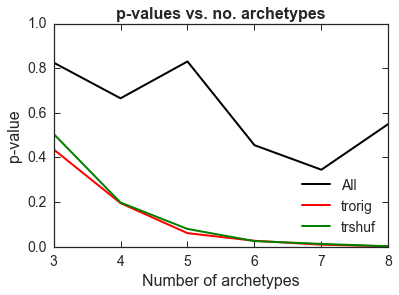

In [46]:
# p < 0.01
plt.figure(figsize=(6,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.title("p-values vs. no. archetypes", fontsize=16, fontweight="bold")
plt.plot(arcs, p_values["arcsig"], c="k", lw=2, ls="solid", alpha=1, label="All")
plt.plot(arcs, t_ratio_orig["arcsig"], c="r", lw=2, ls="solid", alpha=1, label="trorig")
plt.plot(arcs, t_ratio_shuf["arcsig"], c="g", lw=2, ls="solid", alpha=1, label="trshuf")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim([0, 1])
plt.legend(fontsize=14, loc=4)

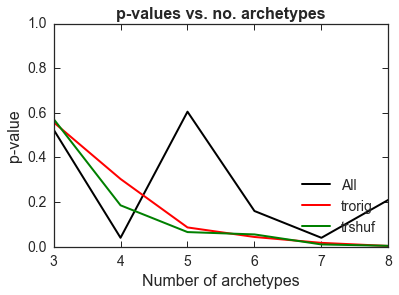

In [32]:
# p < 0.01
plt.figure(figsize=(6,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.title("p-values vs. no. archetypes", fontsize=16, fontweight="bold")
plt.plot(arcs, p_values["arcsig"], c="k", lw=2, ls="solid", alpha=1, label="All")
plt.plot(arcs, t_ratio_orig["arcsig"], c="r", lw=2, ls="solid", alpha=1, label="trorig")
plt.plot(arcs, t_ratio_shuf["arcsig"], c="g", lw=2, ls="solid", alpha=1, label="trshuf")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim([0, 1])
plt.legend(fontsize=14, loc=4)

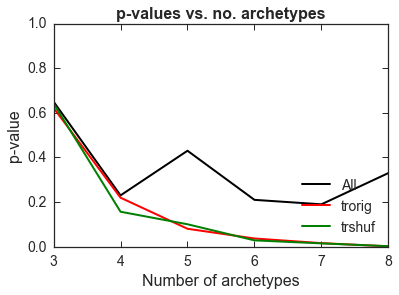

In [28]:
# p < 0.01
plt.figure(figsize=(6,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.title("p-values vs. no. archetypes", fontsize=16, fontweight="bold")
plt.plot(arcs, p_values["arcsig"], c="k", lw=2, ls="solid", alpha=1, label="All")
plt.plot(arcs, t_ratio_orig["arcsig"], c="r", lw=2, ls="solid", alpha=1, label="trorig")
plt.plot(arcs, t_ratio_shuf["arcsig"], c="g", lw=2, ls="solid", alpha=1, label="trshuf")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim([0, 1])
plt.legend(fontsize=14, loc=4)

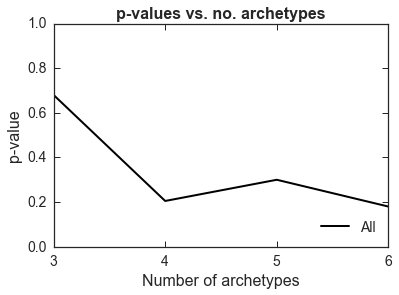

In [22]:
# p < 0.01
plt.figure(figsize=(6,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.title("p-values vs. no. archetypes", fontsize=16, fontweight="bold")
plt.plot(arcs, p_values["arcsig"], c="k", lw=2, ls="solid", alpha=1, label="All")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim([0, 1])
plt.legend(fontsize=14, loc=4)

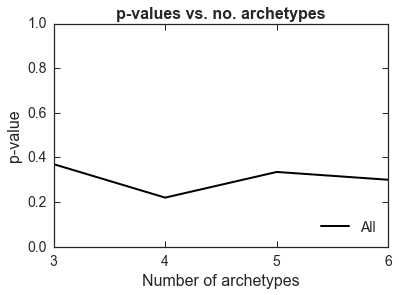

In [19]:
# p < 0.02
plt.figure(figsize=(6,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.title("p-values vs. no. archetypes", fontsize=16, fontweight="bold")
plt.plot(arcs, p_values["arcsig"], c="k", lw=2, ls="solid", alpha=1, label="All")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim([0, 1])
plt.legend(fontsize=14, loc=4)

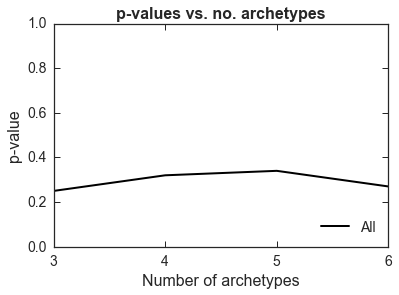

In [16]:
# p < 0.05
plt.figure(figsize=(6,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.title("p-values vs. no. archetypes", fontsize=16, fontweight="bold")
plt.plot(arcs, p_values["arcsig"], c="k", lw=2, ls="solid", alpha=1, label="All")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim([0, 1])
plt.legend(fontsize=14, loc=4)

In [ ]:
"""H_0: The ratio between archetype and convex hull volumes is not greater for unshuffled data."""

arcs = range(3,7)
delta = 0.0
maxruns = 200
num_iter = 1
    
p_values = defaultdict(list)
t_ratio_orig = defaultdict(list)
t_ratio_shuf = defaultdict(list)

for combination in [(0,1), (0,), (1,)]:
    #subset = map(lambda x: x[0], filter(lambda x: x[1] in combination, zip(range(len(clusters)), clusters)))
    X0 = np.delete(Xtz, [], axis=0)[:, subset]
    N, M = X0.shape
    pca = PCA(n_components=X0.shape[1])
    Xpca = pca.fit_transform(X0)
    for a in arcs:
        Xpca_d = Xpca[:, :(a-1)]

        p_arr = []
        for i in range(maxruns):
            while True:
                try:
                    XC, _, _, _, _ = PCHA(Xpca_b.T, a, delta=delta)
                    break
                except:
                    print("Init exception, running again.")
            orig_ratio = ConvexHull(XC.T).volume / ConvexHull(Xpca_b).volume
            Xpca_shuf = col_shuf(Xpca_b)
            shuf_ratios = []
            for _ in range(num_iter):
                while True:
                    try:
                        XC_shuf, _, _, _, _ = PCHA(Xpca_shuf.T, a, delta=delta)
                        break
                    except:
                        print("Init exception, running again.")
                shuf_ratios.append(ConvexHull(XC_shuf.T).volume / ConvexHull(Xpca_shuf).volume)

            #if i > 0 and i % 10 == 0:
            #    print(i)
            
            p_arr.append(orig_ratio < max(shuf_ratios))

        print(a)
        p_values[combination].append(np.mean(p_arr))
        t_ratio_orig[combination].append(orig_ratio)
        t_ratio_shuf[combination].append(max(shuf_ratios))

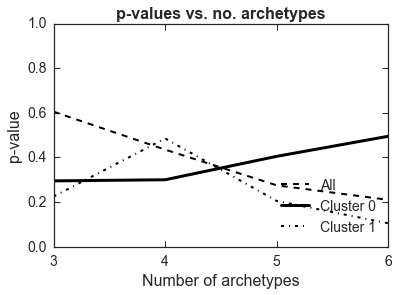

In [63]:
plt.figure(figsize=(6,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.title("p-values vs. no. archetypes", fontsize=16, fontweight="bold")
plt.plot(arcs, p_values[(0, 1)], c="k", lw=2, ls="dashed", alpha=1, label="All")
plt.plot(arcs, p_values[(0,)], c="k", lw=3, ls="solid", alpha=1, label="Cluster 0")
plt.plot(arcs, p_values[(1,)], c="k", lw=2, ls="dashdot", alpha=1, label="Cluster 1")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim([0, 1])
plt.legend(fontsize=14, loc=4)

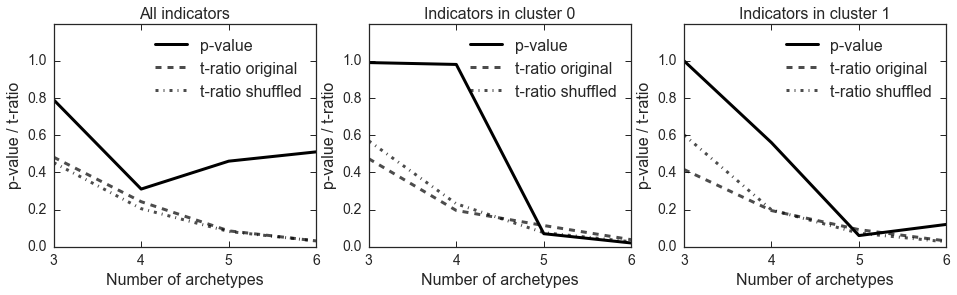

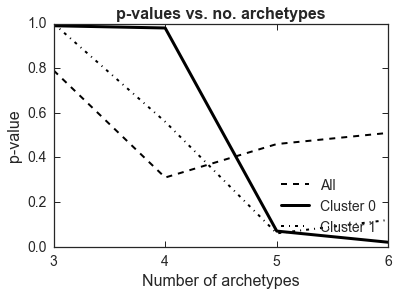

In [155]:
plt.figure(figsize=(16,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE

plt.subplot(1, 3, 1)
plt.title("All indicators", fontsize=16)
plt.plot(arcs, p_values[(0, 1)], c="k", lw=3, alpha=1, label="p-value")
plt.plot(arcs, t_ratio_orig[(0, 1)], c="k", lw=3, ls="dashed", alpha=0.7, label="t-ratio original")
plt.plot(arcs, t_ratio_shuf[(0, 1)], c="k", lw=3, ls="dashdot", alpha=0.7, label="t-ratio shuffled")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value / t-ratio", fontsize=16)
plt.ylim([0, 1.2])
plt.legend(fontsize=16)

plt.subplot(1, 3, 2)
plt.title("Indicators in cluster 0", fontsize=16)
plt.plot(arcs, p_values[(0,)], c="k", lw=3, alpha=1, label="p-value")
plt.plot(arcs, t_ratio_orig[(0,)], c="k", lw=3, ls="dashed", alpha=0.7, label="t-ratio original")
plt.plot(arcs, t_ratio_shuf[(0,)], c="k", lw=3, ls="dashdot", alpha=0.7, label="t-ratio shuffled")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value / t-ratio", fontsize=16)
plt.ylim([0, 1.2])
plt.legend(fontsize=16)

plt.subplot(1, 3, 3)
plt.title("Indicators in cluster 1", fontsize=16)
plt.plot(arcs, p_values[(1,)], c="k", lw=3, alpha=1, label="p-value")
plt.plot(arcs, t_ratio_orig[(1,)], c="k", lw=3, ls="dashed", alpha=0.7, label="t-ratio original")
plt.plot(arcs, t_ratio_shuf[(1,)], c="k", lw=3, ls="dashdot", alpha=0.7, label="t-ratio shuffled")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value / t-ratio", fontsize=16)
plt.ylim([0, 1.2])
plt.legend(fontsize=16)

plt.savefig(TMPFIGPATH+"p_values_for_archetypes_on_each_pareto_front_kd.pdf")

plt.figure(figsize=(6,4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.title("p-values vs. no. archetypes", fontsize=16, fontweight="bold")
plt.plot(arcs, p_values[(0, 1)], c="k", lw=2, ls="dashed", alpha=1, label="All")
plt.plot(arcs, p_values[(0,)], c="k", lw=3, ls="solid", alpha=1, label="Cluster 0")
plt.plot(arcs, p_values[(1,)], c="k", lw=2, ls="dashdot", alpha=1, label="Cluster 1")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value", fontsize=16)
plt.ylim([0, 1])
plt.legend(fontsize=14, loc=4)

plt.savefig(TMPFIGPATH+"p_values_for_archetypes_on_each_pareto_front_kd_onefig.pdf")

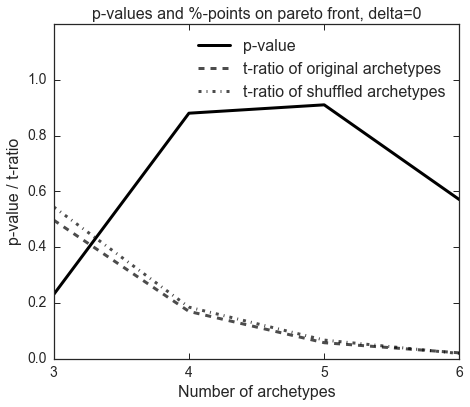

In [32]:
plt.figure(figsize=(16,6))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE

plt.subplot(1, 2, 1)
plt.title("p-values and %-points on pareto front, delta=0", fontsize=16)
plt.plot(arcs, p_values, c="k", lw=3, alpha=1, label="p-value")
plt.plot(arcs, t_ratio_orig, c="k", lw=3, ls="dashed", alpha=0.7, label="t-ratio of original archetypes")
plt.plot(arcs, t_ratio_shuf, c="k", lw=3, ls="dashdot", alpha=0.7, label="t-ratio of shuffled archetypes")
plt.xticks(arcs, fontsize=14)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.xlabel("Number of archetypes", fontsize=16)
plt.ylabel("p-value / t-ratio", fontsize=16)
plt.ylim([0, 1.2])
plt.legend(fontsize=16)

plt.savefig(TMPFIGPATH+"p_values_cluster_1_new_delta0.pdf")

In [30]:
TMPFIGPATH

'visualisation/figures/'

### FIND OUT WHICH INDICATORS ARE RESPONSIBLE FOR HIGH P-VALUES

In [360]:
p_values_tmp = p_values
percent_points_inside_tmp = percent_points_inside

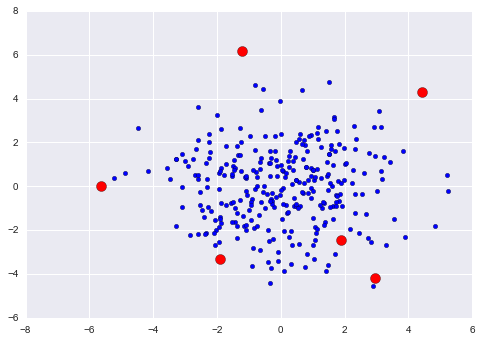

In [344]:
plt.figure()
plt.scatter(XC[0, :], XC[1, :], c="r", s=100)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c="b")

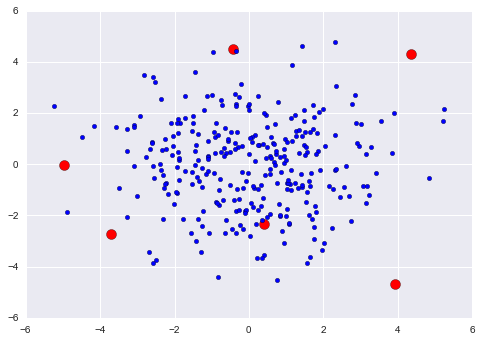

In [340]:
plt.figure()
plt.scatter(XC[0, :], XC[1, :], c="r", s=100)
plt.scatter(Xpca_r[:, 0], Xpca_r[:, 1], c="b")

In [229]:
Xpca.shape

(300, 2)

In [216]:
X0.shape

(300, 30)

## Show archetypes

### PCA + PCHA for each individual tc

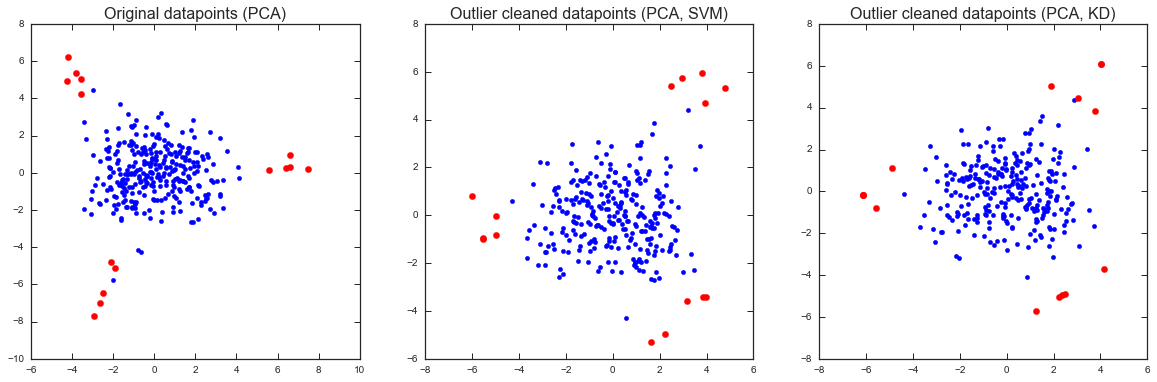

In [428]:
def plot_archetypes(X, num_iter):
    X_pca = PCA(n_components=2).fit_transform(X)
    
    N, M = X_pca.shape
    
    X_arc = np.empty((0, 2))
    for i in range(num_iter):
        X_pca_b = X_pca[np.unique(np.random.randint(0, N, N)), :].T
        while True:
            try:
                A, _, _, _, _ = PCHA(X_pca_b, 3, delta=0.4)
                break
            except:
                pass
        X_arc = np.vstack([X_arc, A.T])
        
    plt.scatter(X_pca[:, 0], X_pca[:, 1], color="b")
    plt.scatter(X_arc[:, 0], X_arc[:, 1], color="r", s=40)

num_iter = 5
#subset = map(lambda x: x[0], filter(lambda x: x[1] in [0], zip(range(len(clusters)), clusters)))
subset = subsets[3]

plt.figure(0, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)
plot_archetypes(Xtz[:, subset], num_iter)

plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)
plot_archetypes(Xtz_clean_svm[:, subset], num_iter)

plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)
plot_archetypes(Xtz_clean_kd[:, subset], num_iter)

plt.show()

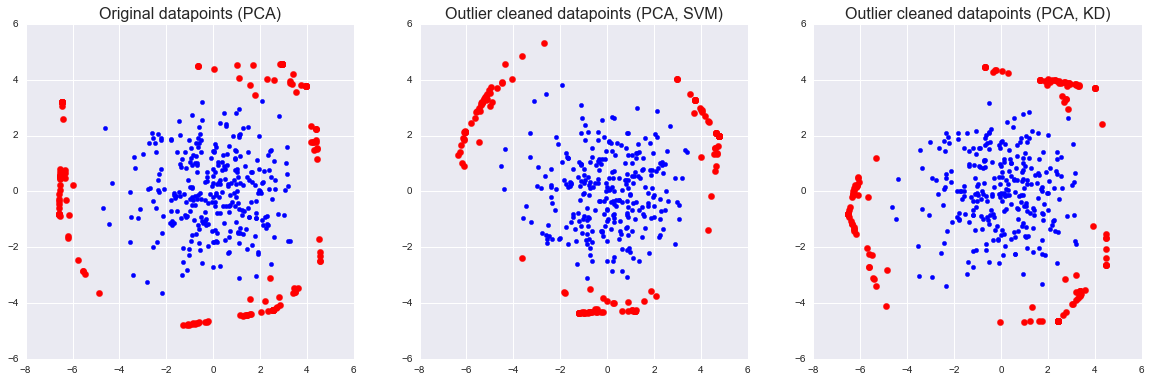

In [34]:
def plot_archetypes(X, num_iter):
    X_pca = decomposition.PCA(n_components=2).fit_transform(X)
    
    N, M = X_pca.shape
    
    X_arc = np.empty((0, 2))
    for i in range(num_iter):
        X_pca_b = X_pca[np.unique(np.random.randint(0, N, N)), :].T
        A, _, _, _, _ = PCHA(X_pca_b, 3, delta=0.4)
        X_arc = np.vstack([X_arc, A.T])
        
    plt.scatter(X_pca[:, 0], X_pca[:, 1], color="b")
    plt.scatter(X_arc[:, 0], X_arc[:, 1], color="r", s=40)

num_iter = 50
subset = map(lambda x: x[0], filter(lambda x: x[1] == 1, zip(range(len(clusters)), clusters)))

plt.figure(0, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)
plot_archetypes(np.delete(Xtz, [], axis=0)[:, subset], num_iter)

plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)
plot_archetypes(np.delete(Xtz, outliers_svm, axis=0)[:, subset], num_iter)

plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)
plot_archetypes(np.delete(Xtz, outliers_kd, axis=0)[:, subset], num_iter)

plt.show()

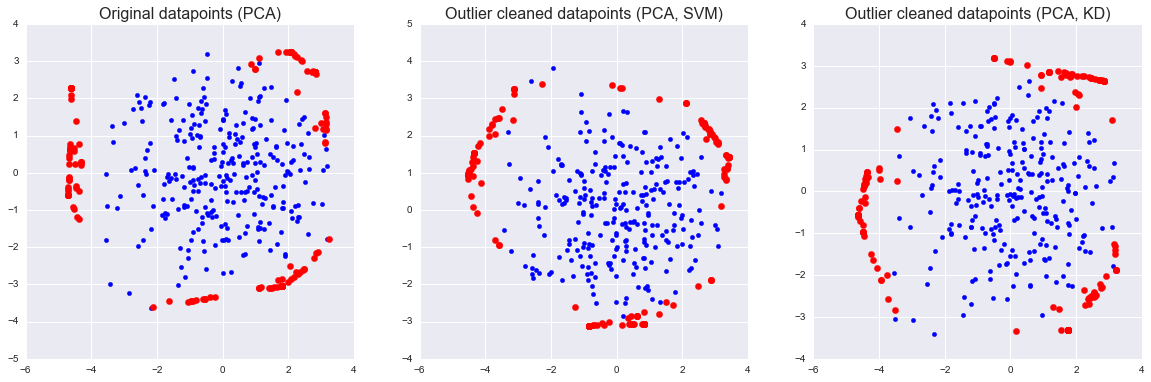

In [36]:
def plot_archetypes(X, num_iter):
    X_pca = decomposition.PCA(n_components=2).fit_transform(X)
    
    N, M = X_pca.shape
    
    X_arc = np.empty((0, 2))
    for i in range(num_iter):
        X_pca_b = X_pca[np.unique(np.random.randint(0, N, N)), :].T
        while True:
            try:
                A, _, _, _, _ = PCHA(X_pca_b, 3, delta=0.0)
                break
            except:
                pass
        X_arc = np.vstack([X_arc, A.T])
        
    plt.scatter(X_pca[:, 0], X_pca[:, 1], color="b")
    plt.scatter(X_arc[:, 0], X_arc[:, 1], color="r", s=40)

num_iter = 50
subset = map(lambda x: x[0], filter(lambda x: x[1] == 1, zip(range(len(clusters)), clusters)))

plt.figure(0, figsize=(20,6))

plt.subplot(1,3,1)
plt.title("Original datapoints (PCA)", fontsize=16)
plot_archetypes(np.delete(Xtz, [], axis=0)[:, subset], num_iter)

plt.subplot(1,3,2)
plt.title("Outlier cleaned datapoints (PCA, SVM)", fontsize=16)
plot_archetypes(np.delete(Xtz, outliers_svm, axis=0)[:, subset], num_iter)

plt.subplot(1,3,3)
plt.title("Outlier cleaned datapoints (PCA, KD)", fontsize=16)
plot_archetypes(np.delete(Xtz, outliers_kd, axis=0)[:, subset], num_iter)

plt.show()

## Compute percetage of points on convex hull

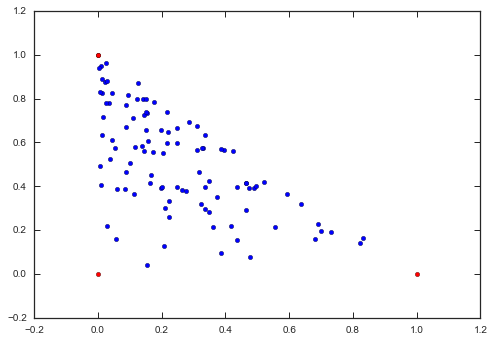

In [149]:
def sample_points_in_simplex(simp, num_points, noise):
    d = simp.shape[1]
    A = np.random.rand(d, num_points); A.sort(axis=0); A = A.T
    A = np.hstack([np.zeros((num_points, 1)), A, np.ones((num_points, 1))])
    A = A[:, range(1, d+2)] - A[:, range(d+1)]
    return np.dot(A, simp) + np.dot(noise,(np.random.rand(num_points,d)-0.5))

arcs = np.array([[1, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0]])
points = sample_points_in_simplex(arcs, 100, 0)

plt.scatter(arcs[:, 0], arcs[:, 1], c="r")
plt.scatter(points[:, 0], points[:, 1], c="b")
plt.show()

In [348]:
N = 30000; d = 8
p = 2 * np.random.rand(N, d) - 1
p = p[np.sum(p * p, 1)**.5 <= 1, :]
p.shape

(481, 8)

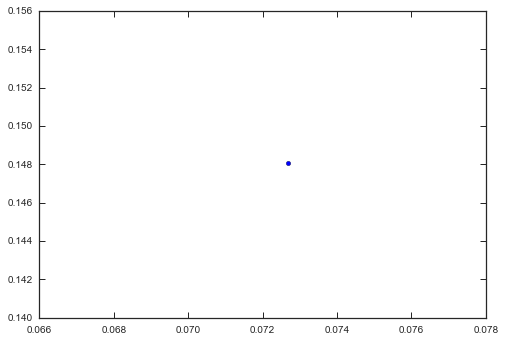

In [342]:
plt.scatter(p[:, 0], p[:, 1])

## 

In [349]:
def sample_points_inside_nsphere(d):
    p = 2 * np.random.rand(100000, d) - 1
    return p[np.sum(p * p, 1)**.5 <= 1, :]

In [352]:
x, yd, yds, yn, ys = [], [], [], [], []
for d in range(2, 8):
    Xd = decomposition.PCA(n_components=d).fit_transform(Xtz)
    Xds = decomposition.PCA(n_components=d).fit_transform(col_shuf(Xtz))
    Xn = np.random.normal(0, 1, size=Xd.shape)
    Xs = sample_points_inside_nsphere(d)
    x.append(d)
    yd.append(len(ConvexHull(Xd).vertices) * 1.0 / Xd.shape[0] * 100)
    yds.append(len(ConvexHull(Xds).vertices) * 1.0 / Xds.shape[0] * 100)
    yn.append(len(ConvexHull(Xn).vertices) * 1.0 / Xn.shape[0] * 100)
    ys.append(len(ConvexHull(Xs).vertices) * 1.0 / Xs.shape[0] * 100)

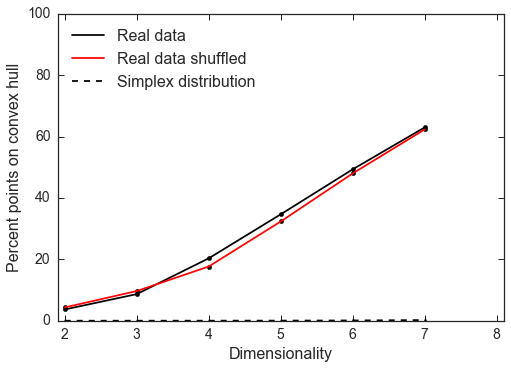

In [351]:
plt.figure()
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE
plt.plot(x, yd, ls="solid", c="k", label="Real data")
plt.scatter(x, yd, c="k")
plt.plot(x, yds, ls="solid", c="r", label="Real data shuffled")
plt.scatter(x, yds, c="k")
#plt.plot(x, yn, ls="dashed", c="k", label="Normal distribution")
#plt.scatter(x, yn, c="k")
plt.plot(x, ys, ls="dashed", c="k", label="Simplex distribution")
plt.scatter(x, ys, c="k", marker="^")
plt.legend(loc=2, fontsize=16)
plt.xticks(range(2, 9), fontsize=14)
plt.yticks([0, 20, 40, 60, 80, 100], fontsize=14)
plt.xlim([1.9, 8.1])
plt.ylim([0, 100])
plt.xlabel("Dimensionality", fontsize=16)
plt.ylabel("Percent points on convex hull", fontsize=16)
plt.show()

# Pareto clustering

In [197]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import networkx as nx
from collections import defaultdict
from pareto_clustering.cluster.pareto_cluster import Pareto_cluster

### Cap too correlating features

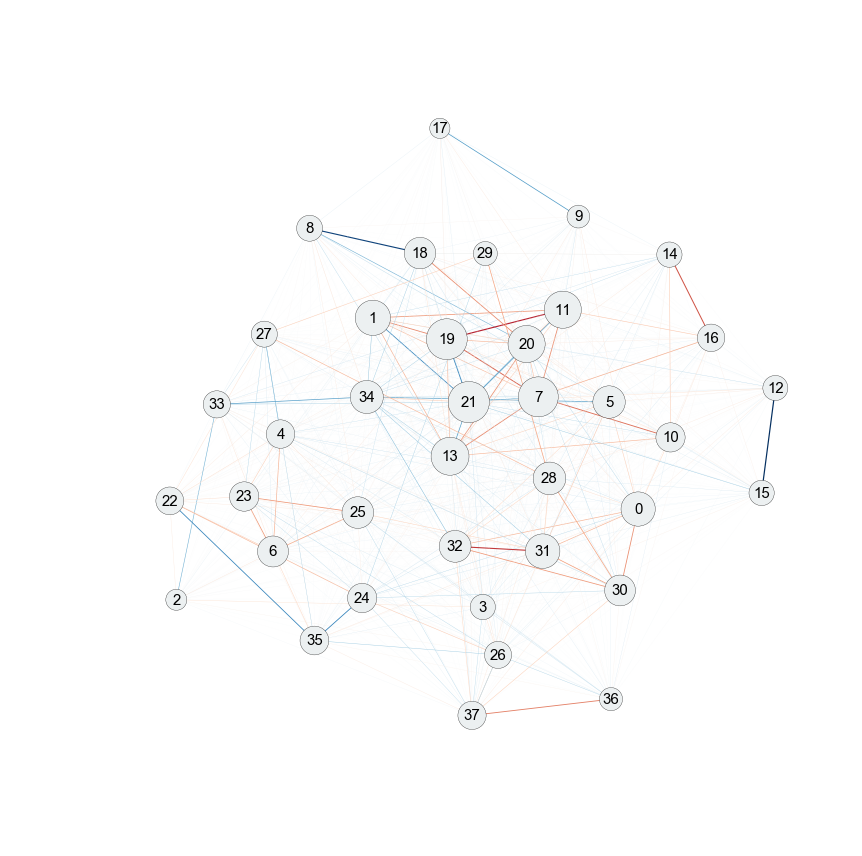

In [198]:
X = Xtz_clean_svm.copy()
valid_users = Xtz_clean_svm_valid_users

feat_blacklist = []

sigma = np.corrcoef(X.T)
remove_cols = []

G = nx.Graph()

cutoff = 1
for i in range(sigma.shape[0]):
    for j in range(sigma.shape[1]):
        
        G.add_edge(i, j, weight=abs(sigma[i, j]), color=sigma[i, j])
        
        if i >= j:# or j in remove_cols:
            continue
            
        if abs(sigma[i, j]) > cutoff:
            print "del --x %s" % feature_name_map[cl(feat_names[j])]
            print "cor --> %s ||" % feature_name_map[cl(feat_names[i])],
            #print "del --x %s" % cl(feat_names[j])
            #print "cor --> %s ||" % cl(feat_names[i]),
            print sigma[i, j]
            print
            
            remove_cols.append(j)

## ASSIGN
X = np.delete(X, remove_cols, axis=1)
feat_names = [cl(fn) for i, fn in enumerate(feat_names) if i not in remove_cols]


## SHOW GRAPH OF CORRELATION COEF MATRIX WITH CAP ENFORCED
plt.figure(figsize=(12,12))
plt.axis('off')
plt.tight_layout()

pos = nx.spring_layout(G, k=0.2)

edge_widths = np.log(np.array([abs(G[u][v]['weight']) for u,v in G.edges()])+1)*2
edge_colors = np.array([G[u][v]['color']  for u,v in G.edges()]).clip(min=-cutoff, max=cutoff)

degrees = [G.degree(weight='weight')[n] for n in G.nodes()]
node_sizes = (np.array(degrees)/np.mean(degrees)*30)**2
node_colors = ['#e74c3c' if n in remove_cols else '#ecf0f1' for n in G.nodes()]

label_names = dict((n, n) for n in G.nodes()) # ''.join(feat_names[n].split("_allweek__allday__"))

edges = nx.draw_networkx_edges(G, pos=pos, width=edge_widths, edge_color=edge_colors, edge_cmap=plt.cm.RdBu_r)
nodes = nx.draw_networkx_nodes(G, pos=pos, with_labels=False, node_size=node_sizes, node_color=node_colors)
labels = nx.draw_networkx_labels(G, pos=pos, font_size=15, labels=label_names)

plt.show()

In [516]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.72, min_samples=2, metric='precomputed').fit(1-sigma)
sorted(zip(clusters, [feature_name_map[n] for n in feat_names]), key=lambda x: x[0])

[(0, 'Has many phone contacts'),
 (0, 'Has long ongoing text conversations'),
 (0, 'Avoids looking at phone when social'),
 (0, 'Makes long calls'),
 (0, 'Spends long time with people'),
 (0, 'Frequently calls and texts'),
 (0, 'Around people a lot'),
 (0, 'Response time to texts depends on receiver'),
 (0, 'Response time to missed calls depends on receiver'),
 (0, 'Sends more texts than receives'),
 (0, 'Responds quickly to missed calls'),
 (0, 'Responds quickly to texts'),
 (0, 'Responds to texts immediately'),
 (0, 'Prefers calling over texting'),
 (0, 'Mostly goes in groups'),
 (0, 'Meets people from school outside of school'),
 (0, 'Mostly meets people at campus'),
 (0, 'Spends time at campus'),
 (0, 'Meets with people in weekly patterns'),
 (0, 'Interacts with strangers'),
 (0, 'Visits many places only once'),
 (0, 'Distributes time at different locations evenly'),
 (0, 'Visits many different places'),
 (0, 'Goes places often'),
 (0, 'Spends short time at locations'),
 (0, 'Keeps

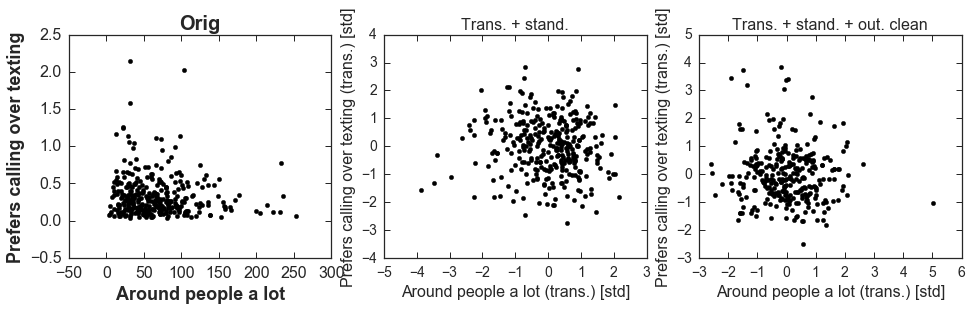

In [18]:
import re

X1 = Xo[0, :, :].T

import re
mystr = """del --x Is more likely to conclude text conversations with some people than others
cor --> Is more likely to initiate text conversations with some people than others || 0.645807458139"""

feat_i_n, feat_j_n = tuple([w.strip() for w in re.findall(r"[A-Z][\w ]+", mystr)])

feat_i_n = "Around people a lot"
feat_j_n = "Prefers calling over texting"

feat_i = dict((v, k) for k, v in feature_name_map.items())[feat_i_n]
feat_j = dict((v, k) for k, v in feature_name_map.items())[feat_j_n]

i = map(cl, feat_nameso).index(feat_i)
j = map(cl, feat_nameso).index(feat_j)

plt.figure(figsize=(16, 4))
sns.set_style("ticks", {"xtick.direction": "in", "ytick.direction": "in"})  # <-- STYLE

plt.subplot(1,3,1)
plt.title("Orig", fontsize=20, fontweight='bold')
plt.scatter(X1[:, i], X1[:, j], c="k")
plt.xlabel(feat_i_n, fontsize=18, fontweight='bold')
plt.ylabel(feat_j_n, fontsize=18, fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1,3,2)
plt.title("Trans. + stand.", fontsize=16)
plt.scatter(scale(tr_scheme[feat_i](X1[:, i])), scale(tr_scheme[feat_j](X1[:, j])), c="k")
plt.xlabel("%s (trans.) [std]" % feat_i_n, fontsize=16)
plt.ylabel("%s (trans.) [std]" % feat_j_n, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1,3,3)
plt.title("Trans. + stand. + out. clean", fontsize=16)
plt.scatter(Xtz_clean_kd[:, i], Xtz_clean_kd[:, j], c="k")
plt.xlabel("%s (trans.) [std]" % feat_i_n, fontsize=16)
plt.ylabel("%s (trans.) [std]" % feat_j_n, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

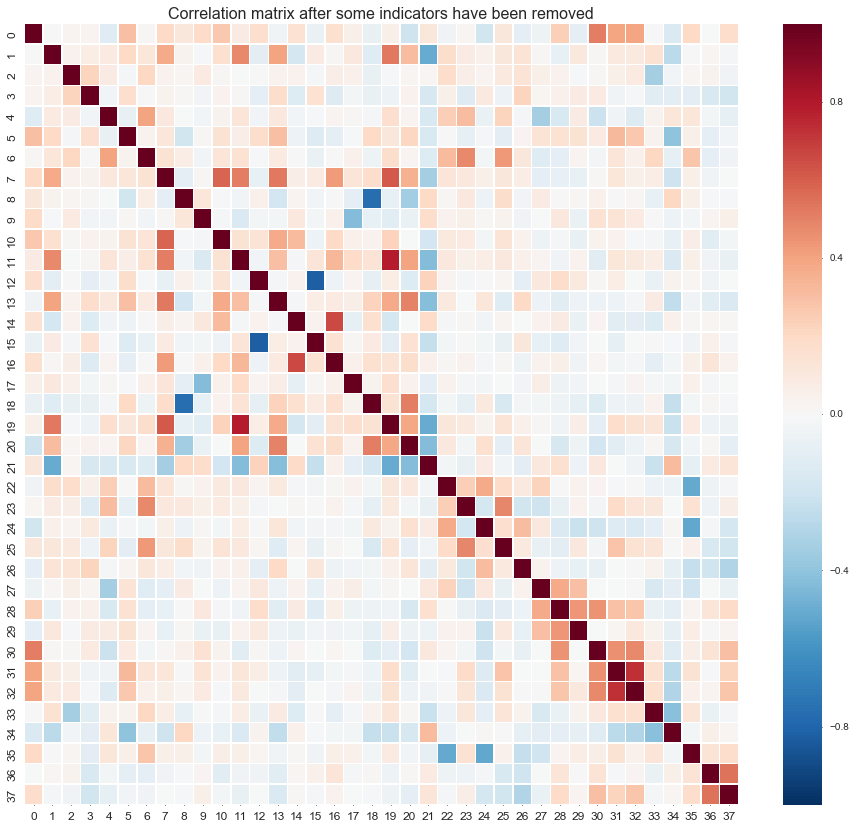

[(0, 'number_of_contacts_text+call'),
 (1, 'duration_text'),
 (2, 'ratio_social_screen_alone_screen_physical+screen'),
 (3, 'duration_call'),
 (4, 'duration_physical'),
 (5, 'number_of_interactions_text+call'),
 (6, 'number_of_interactions_physical'),
 (7, 'percent_concluded_conversations_text_mean'),
 (8, 'response_delay_text_std'),
 (9, 'response_delay_call_std'),
 (10, 'percent_initiated_conversations_text_mean'),
 (11, 'response_rate_text+call_std'),
 (12, 'percent_initiated_conversations_call_mean'),
 (13, 'balance_of_interactions_text'),
 (14, 'percent_initiated_conversations_text_std'),
 (15, 'percent_initiated_conversations_call_std'),
 (16, 'percent_concluded_conversations_text_std'),
 (17, 'response_delay_call_mean'),
 (18, 'response_delay_text_mean'),
 (19, 'response_rate_text+call_mean'),
 (20, 'first_seen_response_rate_text+screen'),
 (21, 'ratio_call_text_text+call'),
 (22, 'overlap_conversations_physical'),
 (23, 'percent_outside_campus_from_campus_physical+stop'),
 (24,

In [19]:
plt.figure(figsize=(16,14))
plt.title("Correlation matrix after some indicators have been removed", fontsize=16)
sns.heatmap(pd.DataFrame(np.corrcoef(X.T)))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()
[(i, '_'.join(n.split("__allweek__allday__"))) for i, n in enumerate(feat_names)]

## Feature Selection

#### Backwards

In [8]:
@trytrytry
def t_ratio(X, n_arcs, hull=False):
    X = PCA(n_components=n_arcs-1).fit_transform(X)
    XC = PCHA(X.T, n_arcs, delta=0)[0]
    if hull:
        return ConvexHull(XC.T).volume / ConvexHull(X).volume, ConvexHull(X)
    return ConvexHull(XC.T).volume / ConvexHull(X).volume

def factorial(n):
    if n == 0: return 1
    if n < 0: raise
    return n * factorial(n-1)

def vol_sphere(n, R=1):
    if n == 1: return 2.0 * R
    if n == 2: return np.pi * R**2
    return 2*np.pi / n * vol_sphere(R, n-2)

def vol_simplex(n, R=1.0):
    n = float(n)
    return (2 * R * np.sin(np.arccos(-1.0 / n) / 2))**n / factorial(n) * np.sqrt((n + 1) / 2**n)

def t_ratio_theoretical(ndim, R=1.0):
    return vol_simplex(ndim, R) / vol_sphere(ndim, R)

def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

@trytrytry
def polytope_approximate(points, ndim):
    return PCHA(points, npoints)[0].T

@trytrytry
def t_ratio_approximate(ndim, npoints, R=1.0):
    sphere_num = sample_spherical(ndim*100, ndim)
    sphere_app = PCHA(sphere_num, npoints)[0].A
    simplex = PCHA(sphere_app, ndim+1)[0].A
    return ConvexHull(simplex.T).volume / ConvexHull(sphere_app.T).volume

In [ ]:
fs_arcs = {}
fs_tr_arcs = {}
fs_tr_worst_case_arcs = {}

for n_arcs in range(3, 7):
    subset = map(
        lambda x: x[0],
        filter(
            lambda x: x[1] in [1, 0],
            zip(range(len(clusters)), clusters))
    )
    
    removed_counter = Counter()
    recently_removed = [-1] * 2
    fs = np.empty((0, len(subset)))
    fs_tr = []
    fs_tr_worst_case = []
    selected_against = set()
    while True:
        #print len(set(subset) - selected_against)
        fs_iter = [np.nan] * len(subset)
        full_tr = t_ratio(Xtz[:, list(set(subset) - selected_against)], n_arcs)
        
        start = dt.now()
        remove_candidate = (-1, -0.2)
        for i in set(subset) - selected_against:
            iter_tr = t_ratio(Xtz[:, list(set(subset) - selected_against - {i})], n_arcs)
            i_score = iter_tr - full_tr
            fs_iter[subset.index(i)] = i_score
            remove_candidate = (i, i_score) if i_score > remove_candidate[1] else remove_candidate
        #print "remove-loop", dt.now() - start
        
        recently_removed = recently_removed[1:] + [remove_candidate[0]]
        
        new_full_tr = t_ratio(Xtz[:, list(set(subset) - selected_against - {remove_candidate[0]})], n_arcs)
        
        start = dt.now()
        add_candidate = (-1, 0)
        for i in selected_against - set(recently_removed):
            iter_tr = t_ratio(Xtz[:, list((set(subset) - selected_against) | {i})], n_arcs)
            i_score = iter_tr - new_full_tr
            add_candidate = (i, i_score) if i_score > add_candidate[1] else add_candidate
        #print "add-loop", dt.now() - start
        
        if add_candidate[0] != -1 and removed_counter[add_candidate[0]] < 3:
            fs_iter[subset.index(add_candidate[0])] = add_candidate[1]
            selected_against.remove(add_candidate[0])
            #print remove_candidate, add_candidate
        
        if remove_candidate[0] != -1:
            fs = np.vstack([fs, np.array(fs_iter)])
            selected_against.add(remove_candidate[0])
            removed_counter.update([remove_candidate[0]])
        
        if add_candidate[0] != -1 or remove_candidate[0] != -1:
            start = dt.now()
            tr, hull = t_ratio(Xtz[:, list(set(subset) - selected_against)], n_arcs, True)
            fs_tr.append(tr)
            fs_tr_worst_case.append(t_ratio_approximate(n_arcs-1, len(hull.vertices)))
            #print "update-clause", dt.now() - start
            
        #print recently_removed
            
        else:
            break

        if len(set(subset) - selected_against) < 10:
            break
    
    fs_arcs[n_arcs] = fs
    fs_tr_arcs[n_arcs] = fs_tr
    fs_tr_worst_case_arcs[n_arcs] = fs_tr_worst_case
            
    plt.figure(figsize=tuple(np.array(fs.shape[::-1]) * 17.0 / fs.shape[1]))
    plt.title("%d archetypes" % n_arcs, fontsize=40)
    sns.heatmap(fs.T)
    plt.show()
    fig = plt.figure(figsize=(12.25,1))
    ax = fig.add_subplot(1, 1, 1)
    ax.yaxis.tick_right()
    plt.plot(range(len(fs_tr)), fs_tr)
    plt.plot(range(len(fs_tr)), fs_tr_worst_case)
    plt.show()

In [12]:
def get_best_indicators(num_arcs):
    t_ratio_order = sorted(
        zip(range(len(fs_tr_arcs[num_arcs])), fs_tr_arcs[4]),
        key=lambda x: x[1], reverse=True
    )
    
    best_index = t_ratio_order[0][0]
    
    return [
        i for i, v in 
        enumerate(
            fs_arcs[num_arcs][best_index, :]
        ) if not np.isnan(v)
    ]

subsets = {}
for i in range(3, 7):
    subsets[i] = get_best_indicators(i)

Counter({0: 2,
         1: 4,
         2: 3,
         3: 3,
         4: 2,
         5: 1,
         6: 1,
         8: 3,
         9: 1,
         10: 2,
         11: 3,
         12: 1,
         14: 3,
         15: 1,
         16: 3,
         17: 3,
         18: 2,
         19: 2,
         20: 2,
         21: 2,
         22: 2,
         23: 1,
         24: 3,
         25: 3,
         26: 3,
         27: 2,
         28: 4,
         29: 2,
         30: 2,
         31: 3,
         32: 3,
         33: 1,
         35: 2,
         36: 2,
         37: 2})

In [405]:
fs_arcs[4].shape

(49, 38)

In [380]:
fs_tr_worst_case

[None, 1.0, 1.0, 1.0, 1.0, None, None]

In [359]:
t_ratio(Xtz[:, list(set(subset) - selected_against)], n_arcs)

0.4956769290872744

In [348]:
print t_ratio_theoretical(4)
print t_ratio_approximate(4, 9)

0.0231693536269
0.057158551568


In [305]:
tmp = t_ratio_approximate(3, 10)
PCHA(np.random.rand(3, 10), 4)[0]

ValueError: shapes (3,10) and (3,10) not aligned: 10 (dim 1) != 3 (dim 0)

In [312]:
r = np.random.rand(3, 10)
np.sum(tmp[:, :] * tmp[:, :])

ValueError: shapes (3,10) and (3,10) not aligned: 10 (dim 1) != 3 (dim 0)

In [310]:
r

array([[ 0.42473141,  0.61700939,  0.02252516,  0.0744785 ,  0.86639083,
         0.58939789,  0.66862827,  0.84284808,  0.90438104,  0.15561346],
       [ 0.82551394,  0.17530076,  0.07673201,  0.87707161,  0.64794298,
         0.63406602,  0.73689701,  0.61243331,  0.42158158,  0.07356753],
       [ 0.38554581,  0.47774469,  0.47299342,  0.16618691,  0.79687867,
         0.58061092,  0.8759852 ,  0.01582237,  0.31917758,  0.62246508]])

In [333]:
x, y = [], []
for ndim in range(2, 8):
    x.append(ndim)
    y.append(t_ratio_approximate(ndim, ndim+5))

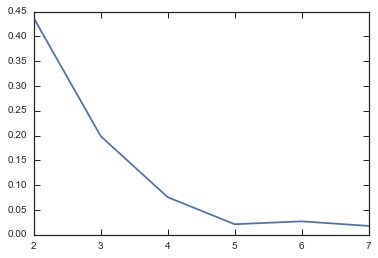

In [334]:
plt.figure()
plt.plot(x, (np.array(y)))
plt.show()

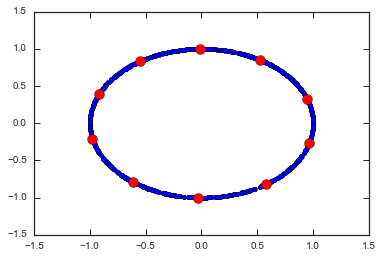

In [231]:
p = sample_spherical(1000, 2).T
a = polytope_approximate(10, 2)
plt.figure()
plt.scatter(p[:, 0], p[:, 1])
plt.scatter(a[:, 0], a[:, 1], c="r", s=100)
plt.show()